In [3]:
using DifferentialEquations; using LinearAlgebra; using Plots; gr();
using LaTeXStrings

# Neutrino Propagation through Earth - matter case


We want to propagate neutrinos as they travel through Earth with a given density distribution. Since neutrinos oscillate, we need solve the following first order, complex domain, 3 coupled diff. equations: 
$$i\frac{d\vec{\nu}}{dt} =
\frac{1}{2E}
\left[
U
\begin{pmatrix}
   m_1^2 & 0 & 0 \\
   0 & m_2^2 & 0 \\
   0 & 0 & m_3^2 \\ 
\end{pmatrix}
U^{+}
+ 2\sqrt{2}G_{F}N_{e}E
\begin{pmatrix}
   1 & 0 & 0 \\
   0 & 0 & 0 \\
   0 & 0 & 0 \\ 
\end{pmatrix}
\right]
  \vec{\nu}$$
  
On the RHS, $i$ is the complex imaginary unit, $t$ is the time, $\vec{\nu} = \{\nu_e, \nu_\mu, \nu_\tau\} $ is the vector of 3 flavor states (hence 3 equations) which can oscillate to each other. On the LHS, $U$ is the Pontecorvo–Maki–Nakagawa–Sakata (PMNS) matrix, $N_{e}$ is the (local) electron number density in matter, and $G_{F}$ is the Fermi constant. The survival probability, used to parameterize the reduction in the measured flux, is calculated as $P(\nu^i \rightarrow \nu^i) = |\langle \nu^i (t)|\nu^i (0)\rangle|^{2}$. For an arbitrary, varying density profile (which is the aim of the current project), there is no general analytical solution to this differential equation. Therefore, it is solved numerically by emitting a neutrino from a given point inside Earth isotropically and using a stepping algorithm to evolve the equation until the neutrino has reached the surface. In this example, it is only solved for a 1D case.

We need to define again constants and units first.

In [4]:
######################
# Bunch of constants #
######################

# Pi
PIGREEK = 3.141592654;
# hbarc
hbarc = 197.327; # MeV * fm 

# Earth
EarthRadius = 6371.0; #km
EarthDiameter = 2*EarthRadius;

# Compute factor = 2.*sqrt(2) * G_F * Y_e * density * E /m_p
# G_F = 8.92 e-8 GeV fm^3 
# Y_e= 0.5 (this is an assumption!) 
# m_n = 1.672 e-24 g 
# density is given in g/cm^3 
# energy is given in GeV
# distance in Km, mass in grams
# to get right dimensions we compute parammsw = factor/(2 * hbarc * E)
Parammsw=1.9207e-4;

# double Angles (from Koike and Sato!)
t12=33.0/180.0*PIGREEK;
t13=asin(sqrt(0.025));
t23 = PIGREEK/4.0;
delta=-90.0 / 180.0*PIGREEK;

# Differences in mass squared
dm32=2.32e-3;
dm21=7.59e-5;

# Neutrino energy
Enu = 0.03; # GeV



We fill up now the PMNS mixing matrix, which is a complex values matrix, and parametrized with 3 angles, 1 complex phase and 3 mass squares. The best measured values are given by the PDG.

In [5]:
# Fill PMNS Mixing matrix, U

# initialize to 0 (note it is implicitely complex type for all elements!)
U = [0.0+im*0.0 0.0+im*0.0 0.0+im*0.0; 0 0 0 ; 0 0 0 ]

# 3 angles (t12, t13, t23), and the complex phase (delta)
c13 = cos(t13);
s13 = sin(t13);
  
c12 = cos(t12);
s12 = sin(t12);
  
c23 = cos(t23);
s23 = sin(t23);

# e1, e2, e3
U[1,1] = c12*c13 + im*0.0     
U[1,2] = s12*c13 + im*0.0    
U[1,3] = s13*cos(delta)- im*s13*sin(delta)  

# mu1, mu2, mu3
U[2,1] = -s12*c23-(c12*s23*s13*cos(delta)) + im*(-c12*s23*s13*sin(delta))
U[2,2] = c12*c23-(s12*s23*s13*cos(delta)) + im*(-s12*s23*s13*sin(delta))
U[2,3] = s23*c13 + im*0.0

#tau1, tau2, tau3
U[3,1] = s12*s23-(c12*c23*s13*cos(delta)) + im*(-c12*c23*s13*sin(delta))
U[3,2] = -c12*s23-(s12*c23*s13*cos(delta)) + im*(-s12*c23*s13*sin(delta))
U[3,3] = c23*c13 + im*0.0

#display(U)

# Filling mass squared differences
Mass = [0.0; 0.0; 0.0]
Mass2 = Mass
Mass[1]=0.0;
Mass[2]=sqrt(Mass[1]*Mass[1]+dm21);
Mass[3]=sqrt(Mass[2]*Mass[2]+dm32);
dm31=Mass[3]*Mass[3]-Mass[1]*Mass[1];
Mass2[1] = Mass[1]*Mass[1]
Mass2[2] = Mass[2]*Mass[2]
Mass2[3] = Mass[3]*Mass[3]
Mmass = [0.0+im*0.0 0.0+im*0.0 0.0+im*0.0; 0 0 0 ; 0 0 0 ]
Mmass[1,1] = Mass2[1] + im*0.0;
Mmass[2,2] = Mass2[2] + im*0.0;
Mmass[3,3] = Mass2[3] + im*0.0;

#display(Mmass)




# Constant matter density

Now we need again to construct the Hamiltonian, this time the RHS will include a constant matter term too.

In [7]:
# Hamiltonian - now for matter as well, using constant density

Udagger = transpose(U)
Udagger = broadcast(conj, Udagger)
#display(Udagger)
H1 = Mmass*Udagger
#display(U)
#display(H1)
H = U*H1
#display(H)
#Base.print_matrix(stdout, H)

p=1.0/(2.0*hbarc*1.0e6*1.0e-18)/Enu/1.0e9 + im*0;
Scale = UniformScaling(p)
Hmat = Scale*H;

# Add matter effects
# Additional potential in matter
density_const = 6.0 # g/cm^3, for a constant density
matterparam= Parammsw*density_const # note: this is to be mupltiplied by +/- one for nu/nubar
HmatConst = Hmat
HmatConst[1,1] = Hmat[1,1] + (matterparam + im*0.0);

Define the diff. equation using the matter Hamiltonian, and solve it.

In [8]:
# The derivatives, for propagating in const density matter
function EqConst(du, u, p, t)
    du[1] = HmatConst[1,1]*u[1]+ HmatConst[1,2]*u[2]+HmatConst[1,3]*u[3]
    du[2] = HmatConst[2,1]*u[1]+ HmatConst[2,2]*u[2]+HmatConst[2,3]*u[3]
    du[3] = HmatConst[3,1]*u[1]+ HmatConst[3,2]*u[2]+HmatConst[3,3]*u[3]

    # multiply by -i
    du[1] = du[1]*(0+1.0*im)
    du[2] = du[2]*(0+1.0*im)
    du[3] = du[3]*(0+1.0*im)
end



EqConst (generic function with 1 method)

In [9]:
# Initial value, in flavour basis, start with nue
u0 = [1.0+im*0.0,0.0+im*0.0,0.0+im*0.0]
tspan = (0.0,EarthRadius)
probConst = ODEProblem(EqConst,u0,tspan)

solConst = solve(probConst,BS3())# Tsit5(), reltol=1e-9)

retcode: Success
Interpolation: 3rd order Hermite
t: 1390-element Array{Float64,1}:
    0.0                 
    0.008198556918627779
    0.04233727579460217 
    0.10113193580567369 
    0.1922988756564245  
    0.3274236547887027  
    0.5161269422077729  
    0.7690839957824714  
    1.095023361480454   
    1.5019507612865377  
    1.995917565559063   
    2.581535387378138   
    3.261612350999674   
    ⋮                   
 6287.216824144433      
 6294.360405153113      
 6300.617570781732      
 6307.164181529678      
 6314.339585529965      
 6322.007193647796      
 6330.231802847415      
 6338.846503832126      
 6348.050774375265      
 6357.713426741755      
 6367.523229464055      
 6371.0                 
u: 1390-element Array{Array{Complex{Float64},1},1}:
 [1.0+0.0im, 0.0+0.0im, 0.0+0.0im]                                          
 [1.0+6.6126e-5im, 0.000181436+1.69149e-5im, 0.000181437-1.66094e-5im]      
 [0.999999+0.000341471im, 0.000936912+9.06327e-5im, 0.000936

# Variable matter density

For variable matter the only change (apart from chosing an appropriate initial position with corresponding density), is to adjust the diff. equation: we have to re-evaluate for the $\nu_e$ state the derivative at each step.

## Earth density model

We need to setup an Earth density model, which will enter as the second term on the RHS of the equation. This a realistic density model, but 1D, meaning that it assumes isotropy, and only depends on the radius.

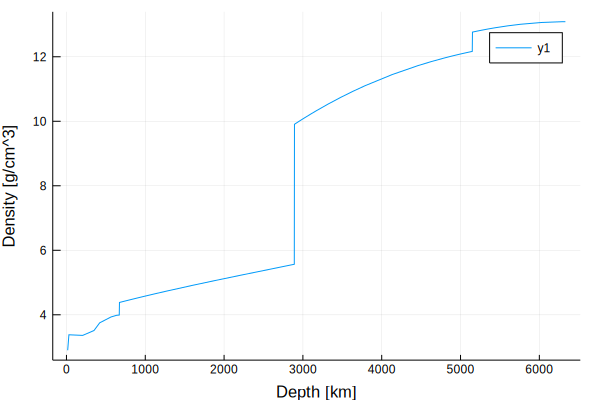

In [10]:
function Density_vs_Depth(x)
    Dist=EarthRadius - x;
    R=Dist/EarthRadius;
    if Dist>0. && Dist<1221.5
        rho_ret = (13.0885-8.8381*R*R)
    elseif Dist >=1221.5 && Dist<3480.
        rho_ret = (12.5815-1.2638*R-3.6426*R*R-5.5281*R*R*R)
    elseif Dist>=3480. && Dist<5701.
        rho_ret = (7.9565-6.4761*R + 5.5283*R*R-3.0807*R*R*R)
    elseif Dist >=5701.0 && Dist<5771.0
        rho_ret = (5.3197-1.4836*R)
    elseif Dist>=5771.0 && Dist<5971.0
        rho_ret = (11.2494-8.0298*R)
    elseif Dist>=5971.0 && Dist<6151.0
        rho_ret = (7.1089-3.8045*R)
    elseif Dist>=6151.0 && Dist<6346.6
        rho_ret = (2.6910+0.6924*R)
    elseif Dist>=6346.6 && Dist<6356.6
        rho_ret = 2.9
        else Dist>=6356.6 && Dist <=EarthRadius
        rho_ret = 2.6
    end
end

# Now plot it
plot(Density_vs_Depth, 0, EarthRadius, xlabel = "Depth [km]", ylabel = "Density [g/cm^3]")

In [11]:
# The derivatives, for propagating in variable density matter, with varying density
function EqVar(du, u, p, t)
    # Additional potential in matter, develop from center R=0 to R=EarthRadius
    density_v = Density_vs_Depth(EarthRadius-t) # g/cm^3
    #matterparam= Parammsw*density_v # note: this is to be mupltiplied by +/- one for nu/nubar
    du[1] = (Hmat[1,1]+(Parammsw*density_v+im*0.0))*u[1]+ Hmat[1,2]*u[2]+Hmat[1,3]*u[3]
    du[2] = Hmat[2,1]*u[1]+ Hmat[2,2]*u[2]+Hmat[2,3]*u[3]
    du[3] = Hmat[3,1]*u[1]+ Hmat[3,2]*u[2]+Hmat[3,3]*u[3]

    # multiply by -i
    du[1] = du[1]*(0+1.0*im)
    du[2] = du[2]*(0+1.0*im)
    du[3] = du[3]*(0+1.0*im)
end

# Initial value, in flavour basis, start with nue
u0 = [1.0+im*0.0,0.0+im*0.0,0.0+im*0.0]
tspan = (0.0, EarthRadius)
probVar = ODEProblem(EqVar,u0,tspan)

ODEProblem with uType Array{Complex{Float64},1} and tType Float64. In-place: true
timespan: (0.0, 6371.0)
u0: Complex{Float64}[1.0+0.0im, 0.0+0.0im, 0.0+0.0im]

In [12]:
solVar = solve(probVar, BS3(), maxiters=1e+06, adaptive = false, dt=0.5)#Tsit5())

retcode: Success
Interpolation: 3rd order Hermite
t: 12743-element Array{Float64,1}:
    0.0
    0.5
    1.0
    1.5
    2.0
    2.5
    3.0
    3.5
    4.0
    4.5
    5.0
    5.5
    6.0
    ⋮  
 6365.5
 6366.0
 6366.5
 6367.0
 6367.5
 6368.0
 6368.5
 6369.0
 6369.5
 6370.0
 6370.5
 6371.0
u: 12743-element Array{Array{Complex{Float64},1},1}:
 [1.0+0.0im, 0.0+0.0im, 0.0+0.0im]                                       
 [0.999863+0.00506146im, 0.0110435+0.00159548im, 0.0110483-0.000449035im]
 [0.999454+0.0103199im, 0.0219658+0.00433362im, 0.0219856+0.000244649im] 
 [0.998775+0.015525im, 0.0326517+0.00819742im, 0.0326968+0.00206409im]   
 [0.997833+0.0206506im, 0.0429887+0.0131577im, 0.0430694+0.00498018im]   
 [0.996638+0.0256716im, 0.0528676+0.0191741im, 0.0529942+0.00895259im]   
 [0.995202+0.0305639im, 0.0621839+0.0261954im, 0.0623666+0.0139301im]    
 [0.993539+0.0353045im, 0.0708387+0.03416im, 0.0710879+0.0198514im]      
 [0.991664+0.0398723im, 0.07874+0.0429969im, 0.0790659+0.02664

12743


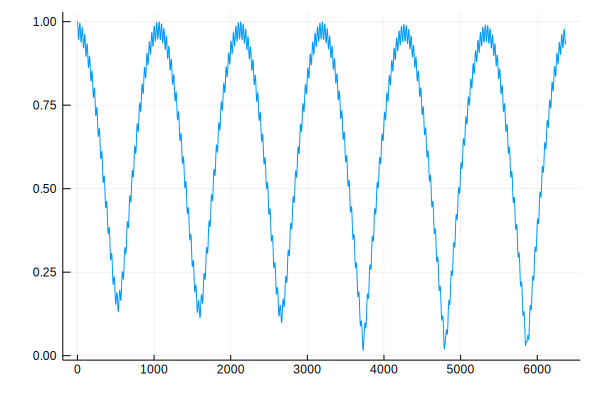

sh: 1: dvipng: not found
dvipng: PNG conversion failed
sh: 1: dvipng: not found
dvipng: PNG conversion failed


In [13]:
# plot the result
AVar = solVar.u
BVar = hcat(AVar...)'
nsteps=length(BVar[:,1])
println(nsteps)
ValuesUVar1 = BVar[1:length(BVar[:,1]), 1]
AbsValuesUVar1 = broadcast(abs, ValuesUVar1)
TimesVar = solVar.t[1:length(BVar[:,1])]
#plot(Times, ValuesU1)
plot(TimesVar, AbsValuesUVar1, legend=false, xlabel = L"\mathrm{Distance [km]}", ylabel = L"\mathrm{Probability} (\nu_{e}\rightarrow\nu_{e}) ")